In [2]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.ndimage import gaussian_filter1d

In [3]:
# Windows Clark WS Path
#spike_times = "Z:/Wu_sleep/m1/SD1/20240914_SD1_test_1200_g0/catgt_20240914_SD1_test_1200_g0/20240914_SD1_test_1200_g0_imec0/imec0_ks25/spike_times.npy"
#spike_clusters = "Z:/Wu_sleep/m1/SD1/20240914_SD1_test_1200_g0/catgt_20240914_SD1_test_1200_g0/20240914_SD1_test_1200_g0_imec0/imec0_ks25/spike_clusters.npy"

# mac macAir Path
file_dir = "/Users/alexandracheng/Desktop/Harris_Lab/Collab/Wu_Sleep/Wu_Sleep_Data/"
#spike_times_file = "/Users/alexandracheng/Desktop/Harris_Lab/Collab/Wu_Sleep/Wu_Sleep_Data/spike_times_m1_1200.npy"
#spike_clusters_file = "/Users/alexandracheng/Desktop/Harris_Lab/Collab/Wu_Sleep/Wu_Sleep_Data/spike_clusters_m1_1200.npy"

# parameters
bin_size = 15000

sample_rate = 30000
sigma = 6

In [4]:
## function for calculating firing rate of each neuron(clsuters)
# Input:
# - spike_time_files = spike_times.npy
# - spike_clusters_file = spike_clusters.npy
# - bin_size = in sample numbers (30kHz), binwidth for calculating firing rate
# - cluster = select for which clusters to calculate firing rate

# Output:
# - fr [cluster #, (total length/ bin width)]: binned firing rate for each cluster
# - t_bins [(total length/ bin width),]: vector of binned time stamp
# - clust_num [int]: number of clusters

def firing_rate(spike_times_file, spike_clusters_file, bin_size, cluster):
    spike_times = np.load(spike_times_file)
    spike_clusters = np.load(spike_clusters_file)

    if cluster == "all":
        clust_ind = np.unique(spike_clusters)
    else:
        clust_ind = cluster
    t_end = np.max(spike_times)
    t_bins = np.arange(0,t_end,bin_size)
    
    clust_num = len(clust_ind)
    fr = np.zeros((len(clust_ind), len(t_bins)-1))
    for i in range(len(clust_ind)):
        spikes_t_ind = spike_times[np.where(spike_clusters == clust_ind[i])[0]]
        spikes_count, edges = np.histogram(spikes_t_ind, t_bins)

        fr[i,:] = spikes_count

    return fr, t_bins[:-1], clust_num

In [5]:
## function for smoothing firing rate via gaussian filter
# Input:
# - fr
# - sigma: standard deviation of gaussian kernel

# Output:
# - fr_smooth

def firing_rate_smooth(fr, sigma):
    fr_smooth = np.zeros(fr.shape)
    for i in range(len(fr_smooth)):
        fr_smooth[i,:] = gaussian_filter1d(fr[i,:], sigma)

    return fr_smooth

In [8]:
# MAIN SCRIPT FOR CALCULATING FIRING RATE

# going through all the different recording sessions
t_stamp = np.arange(900, 2200, 100)

mean_fr_sessions = []

for s in range(len(t_stamp)):
    spike_times_file = file_dir + "spike_times"+"_m1_"+str(t_stamp[s])+".npy"
    spike_clusters_file = file_dir + "spike_clusters"+"_m1_"+str(t_stamp[s])+".npy"

    fr, t_bins, clust_num = firing_rate(spike_times_file, spike_clusters_file, bin_size, "all")
    fr_smooth = firing_rate_smooth(fr, sigma)

    # taking average of binned firing rate for each cluster
    fr_smooth_avg = np.average(fr_smooth, axis=1)

    # save total cluster fr data in vector for each session
    mean_fr_sessions.append(fr_smooth_avg)

In [9]:
len(mean_fr_sessions)

13

{'bodies': [<matplotlib.collections.PolyCollection at 0x12333f310>,
 'cmaxes': <matplotlib.collections.LineCollection at 0x123355e90>,
 'cmins': <matplotlib.collections.LineCollection at 0x1233a3550>,
 'cbars': <matplotlib.collections.LineCollection at 0x12338dc50>}

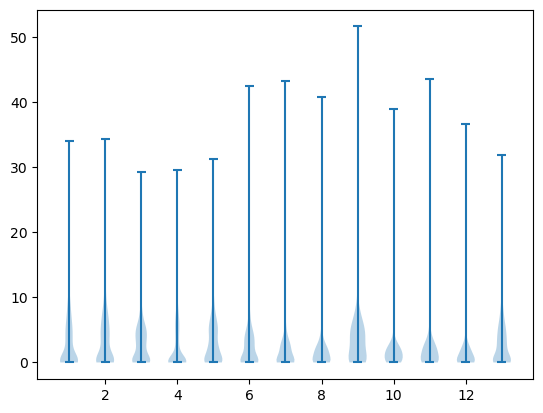

In [10]:
plt.violinplot(mean_fr_sessions)